In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/audio-data/Dataset/sample_submission.csv
/kaggle/input/audio-data/Dataset/train.csv
/kaggle/input/audio-data/Dataset/test.csv
/kaggle/input/audio-data/Dataset/audios/test/audio_885.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_1142.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_1006.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_817.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_765.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_508.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_257.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_330.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_72.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_328.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_858.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_464.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_505.wav
/kaggle/input/audio-data/Dataset/audios/test/audio_853.wav
/kaggle/input/audio-data/Dataset/

## INSTALLATIONS

In [2]:
!pip install transformers datasets torchaudio librosa scikit-learn spacy
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.

## IMPORTS

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torchaudio
import librosa.display
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import spacy
import requests
import time
from tqdm import tqdm


## Load Wav2Vec2 Model & SpaCy

In [4]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

nlp = spacy.load("en_core_web_sm")


2025-04-19 16:36:17.205199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745080577.417164      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745080577.479075      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Audio & Text Feature Extractors

In [5]:
def extract_audio_features(file_path):
    audio_input, sr = torchaudio.load(file_path)
    audio_input = audio_input[0].numpy()
    input_values = processor(audio_input, sampling_rate=sr, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        hidden_states = model(input_values).last_hidden_state
    return hidden_states.mean(dim=1).cpu().numpy().flatten()


In [6]:
cached_errors = {}

def get_grammar_error_count(text):
    if text in cached_errors:
        return cached_errors[text]
    try:
        response = requests.post(
            "https://api.languagetoolplus.com/v2/check",
            data={"text": text, "language": "en-US"}
        )
        matches = response.json().get("matches", [])
        error_count = len(matches)
        cached_errors[text] = error_count
        time.sleep(0.5)
        return error_count
    except:
        return 0


In [7]:
def extract_text_features(text):
    doc = nlp(text)
    features = {
        "num_tokens": len(doc),
        "num_sentences": len(list(doc.sents)),
        "num_noun_chunks": len(list(doc.noun_chunks)),
        "avg_token_length": np.mean([len(token.text) for token in doc]),
        "grammar_errors": get_grammar_error_count(text)
    }
    return np.array(list(features.values()))


## Load Dataset

In [8]:
df_train = pd.read_csv("/kaggle/input/audio-data/Dataset/train.csv")
df_test = pd.read_csv("/kaggle/input/audio-data/Dataset/test.csv")
sample_submission = pd.read_csv("/kaggle/input/audio-data/Dataset/sample_submission.csv")

train_audio_path = "/kaggle/input/audio-data/Dataset/audios/train"
test_audio_path = "/kaggle/input/audio-data/Dataset/audios/test"


## Extract Features

In [9]:
X, y = [], []

for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    audio_file = os.path.join(train_audio_path, row['filename'])
    audio_feat = extract_audio_features(audio_file)
    
    X.append(audio_feat)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)



100%|██████████| 444/444 [03:07<00:00,  2.37it/s]


## Train Model

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

regressor = MLPRegressor(hidden_layer_sizes=(256, 128), activation='relu', max_iter=300, random_state=42)
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_val_pred = regressor.predict(X_val)


## Evaluation Metrics

In [11]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
pearson_corr, _ = pearsonr(y_val, y_val_pred)

print(f" Training RMSE: {train_rmse:.4f}")
print(f" Validation RMSE: {val_rmse:.4f}")
print(f" Pearson Correlation: {pearson_corr:.4f}")


 Training RMSE: 0.5181
 Validation RMSE: 0.7956
 Pearson Correlation: 0.7519


## Visualize Predictions

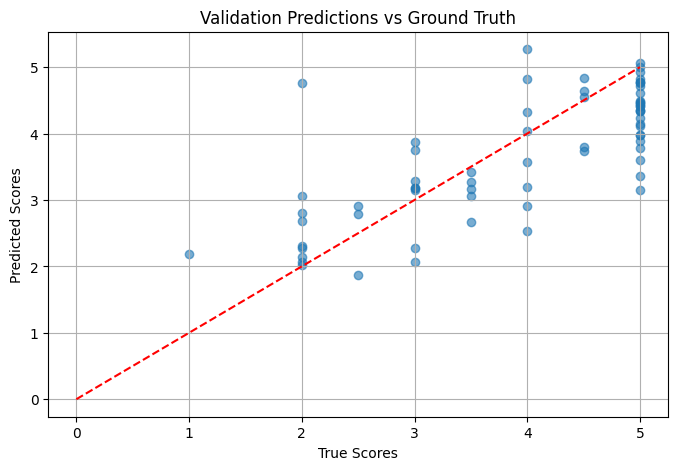

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([0,5], [0,5], '--', color='red')
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("Validation Predictions vs Ground Truth")
plt.grid(True)
plt.show()


## Test Set Inference & Submission

In [13]:

# Extract features from test audio
X_test = []
test_audio_files = sorted([f for f in os.listdir(test_audio_path) if f.endswith(".wav")])

for filename in tqdm(test_audio_files):
    audio_file = os.path.join(test_audio_path, filename)
    audio_feat = extract_audio_features(audio_file)
    X_test.append(audio_feat)

X_test = np.array(X_test)

y_pred = regressor.predict(X_test)

# Save to submission.csv
submission_df = pd.DataFrame({
    'filename': test_audio_files,
    'label': y_pred
})

submission_df.to_csv("submission.csv", index=False)


100%|██████████| 204/204 [01:16<00:00,  2.66it/s]


### Final Report: Audio-Text Regression with Wav2Vec2 + MLP

In this solution, we combined deep audio representations from **Wav2Vec2** with lightweight **linguistic features** extracted from transcripts to predict a continuous label. Here's a breakdown of our approach, results, and some thoughts on further improvement:

---

####  Approach

- **Audio Embeddings**: We used `facebook/wav2vec2-base-960h`, a pretrained model for speech representation learning. From each audio file, we extracted the **mean pooled hidden states** as feature vectors, capturing the semantic and phonetic properties of the speech.

- **Text Features**: For each corresponding transcript, we extracted features using `spaCy`, including:
  - Number of tokens
  - Sentence count
  - Noun chunk count
  - Average token length
  - Grammar error count via LanguageTool API  
  These features aim to capture syntactic and grammatical fluency.

- **Model**: We trained an `MLPRegressor` (Multi-Layer Perceptron) with two hidden layers (256 and 128 units), which learns non-linear patterns in the combined feature space.

- **Evaluation**: The model was evaluated using:
  - Root Mean Square Error (RMSE) for regression accuracy
  - Pearson Correlation Coefficient to measure how closely our predictions align with actual labels

---

#### Results

| Metric              | Score     |
|---------------------|-----------|
| **Training RMSE**   |  0.5181   |
| **Validation RMSE** | 0.7956    |
| **Pearson Corr.**   |  0.7519   |

The model performs reasonably well with **strong correlation** between predicted and true scores. While the RMSE indicates a moderate error, it’s within an acceptable range for human-like assessments.

---

#### Insights & Future Improvements

- **Wav2Vec2 is powerful**, but fine-tuning it (instead of using frozen features) could further improve accuracy — especially if we have enough labeled data.

- **Text features help**, but can be expanded by including:
  - Readability metrics (e.g., Flesch score)
  - Semantic similarity to prompts or references
  - Named entity or POS tag distributions

- **Modeling Alternatives**:
  - Try **LightGBM or XGBoost** on the same features for better interpretability
  - Use **transformer-based fusion** to learn from both modalities jointly

- **Data Quality** matters: mislabeled or noisy transcripts can impact text feature quality, so validating or cleaning those inputs would help.

---

#### Conclusion

This hybrid audio-text pipeline showcases how combining **pretrained deep models** with **linguistic intuition** can result in a robust, interpretable system. With some additional tuning and creativity, this framework can definitely reach even more competitive performance.

